# Setup

In [11]:
%%capture
!pip show transformers
!pip show accelerate
!pip install transformers[torch] -U
!pip install accelerate -U
!pip install transformers
!pip install pytorch-lightning
!pip install --upgrade transformers

# Preprocessing

In [12]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# 1. Prepare Dataset
# 2. Load pretrained Tokenizer, call it with dataset -> encoding
# 3. Build PyTorth Dataset with encodings
# 4. Load pretrained Model
# 5. Load HF Trainer and train it


# Train Data - 52662 rows after pre-processing (done above)
toxicity_train_df = pd.read_csv('toxicity_train.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
toxicity_train_df = toxicity_train_df.dropna()


# Test Data - 7287 rows after pre-processing
toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
toxicity_test_df = toxicity_test_df.dropna()


# Sampling for CPU use
# fraction = 0.1

# toxicity_train_df = toxicity_train_df.sample(frac=fraction, random_state=42)
# toxicity_test_df = toxicity_test_df.sample(frac=fraction, random_state=42)

# # Reset index for consistency
# toxicity_train_df.reset_index(drop=True, inplace=True)
# toxicity_test_df.reset_index(drop=True, inplace=True)

# List of categories to check
categories_to_check = ['obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']

# Check if any category is above the 0.5 threshold
toxicity_train_df[categories_to_check] = toxicity_train_df[categories_to_check].apply(pd.to_numeric, errors='coerce')
toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')

# Check if any category is above the 0.5 threshold
toxicity_train_df['toxic'] = (toxicity_train_df[categories_to_check] >= 0.5).any(axis=1).astype(float)
toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.5).any(axis=1).astype(float)

# Convert boolean values to 1.0 for True and 0.0 for False
toxicity_train_df['toxic'] = toxicity_train_df['toxic'].astype(float)
toxicity_test_df['toxic'] = toxicity_test_df['toxic'].astype(float)

toxicity_train_df = toxicity_train_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]
toxicity_test_df = toxicity_test_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]

<ipython-input-12-efa41bed1490>:21: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26,27,28,29,39,40,41,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  toxicity_train_df = pd.read_csv('toxicity_train.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
<ipython-input-12-efa41bed1490>:26: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)


Test Lengths of DFs

In [13]:
print(len(toxicity_train_df))
print(len(toxicity_test_df))

17016
7287


# Visualization of toxicity in train

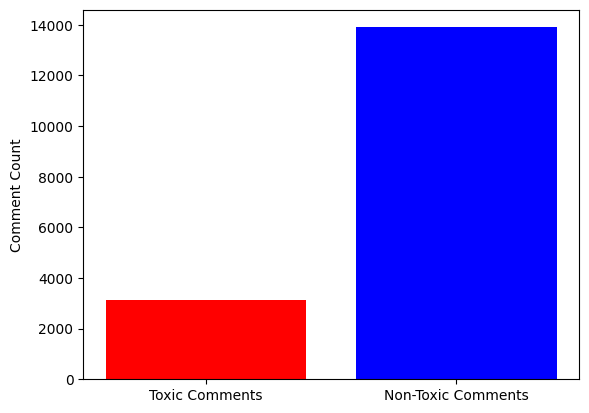

In [14]:
# Count toxic and non-toxic comments
toxic_count = toxicity_train_df['toxic'].sum()
non_toxic_count = len(toxicity_train_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Visualization of toxicity in test

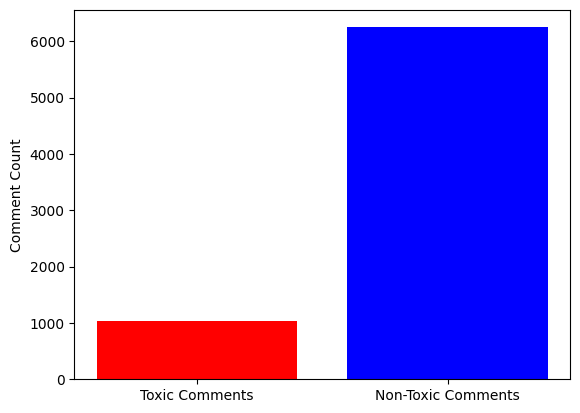

In [15]:
# Count toxic and non-toxic comments
toxic_count = toxicity_test_df['toxic'].sum()
non_toxic_count = len(toxicity_test_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Splitting and Labelling

In [16]:
model_name = "roberta-base"

toxicity_train_df.reset_index(drop=True, inplace=True)
toxicity_test_df.reset_index(drop=True, inplace=True)

X_train = toxicity_train_df[['comment_text']].reset_index(drop=True)
X_train = X_train.dropna()

# y_train = toxicity_train_df[['obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']]
y_train = toxicity_train_df[['toxic']].reset_index(drop=True)
y_train = y_train.dropna()
# toxicity_train_df.info()


# toxicity_test_df.info()
X_test = toxicity_test_df[['comment_text']].reset_index(drop=True)
X_test = X_test.dropna()
# # y_test = toxicity_test_df[['obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']]
y_test = toxicity_test_df[['toxic']].reset_index(drop=True)
y_test = y_test.dropna()


train_texts = X_train['comment_text'].tolist()
train_labels = y_train
test_texts = X_test['comment_text'].tolist()
test_labels = y_test

# See examples of texts & labels
print("train_texts:")
print(train_texts[:5])
print("train_labels:")
print(train_labels[:5])
print("test_texts")
print(test_texts[:5])
print("test_labels:")
print(test_labels[:5])

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

train_texts:
[' so sad they\'re no longer doing it."', ' send them to TES in TN or PAWS in CA."', ' and that was because of people moving here because of that stupid show."', ' either in person or by proxy. That just doesn\'t set right for me."', ' and their god supports them with the action they\'ve taken.  Intelligent or intellectually limited all these militia\'s attract a very dangerous group of people with crackpot ideas.  Please don\'t feel sorry for them they have chosen the path they have taken that could limit your rights and mine."']
train_labels:
   toxic
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
test_texts
['BS !', 'Hodad...does your user handle refer to your daughter??', "Many of them were wearing red Na'i Aupuni shirts.  Does that not show support for federal recognition?", '"Methinks your comment is indicative of your need to understand the Christian faith which does not require the subservience of woman as much as care and love for them by the man - ""as Christ loved

# Dataset

In [17]:
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel


class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_labels = train_labels['toxic'].reset_index(drop=True)
val_labels = val_labels['toxic'].reset_index(drop=True)
test_labels = test_labels['toxic'].reset_index(drop=True)

# Convert Pandas Series to lists
train_labels_list = train_labels.tolist()
val_labels_list = val_labels.tolist()
test_labels_list = test_labels.tolist()

train_dataset = ToxicDataset(train_encodings, train_labels)
val_dataset = ToxicDataset(val_encodings, val_labels)
test_dataset = ToxicDataset(test_encodings, test_labels)

# Tokenizer + Encodings + Training

In [18]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=200,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.02)],
)
trainer.train()

model.save_pretrained('/results/fine_tuned_roberta_model')

# text = "Replace me by any text you'd like."
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
10,0.307400,0.195142
20,0.177800,0.151006
30,0.131700,0.147791
40,0.150600,0.163527
50,0.115700,0.148615
60,0.211000,0.146421
70,0.162800,0.141251
80,0.120600,0.143655
90,0.185600,0.147561
100,0.147000,0.142065


# Evaluation

In [19]:
from sklearn.metrics import accuracy_score, classification_report

# Use the trained model for evaluation
eval_results = trainer.evaluate()

# Print evaluation results
print(eval_results)

# Make predictions on the validation set
predictions = trainer.predict(val_dataset)

# Convert predictions to probabilities and get class labels
predicted_probabilities = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)
predicted_labels = torch.argmax(predicted_probabilities, dim=1)

# Flatten the true labels
true_labels = val_labels.values.flatten()

# Calculate accuracy and print classification report
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")
print(classification_report(true_labels, predicted_labels))

{'eval_loss': 0.1476123332977295, 'eval_runtime': 31.9778, 'eval_samples_per_second': 106.449, 'eval_steps_per_second': 1.689, 'epoch': 0.6}
Accuracy: 0.8207990599294948
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90      2794
         1.0       0.00      0.00      0.00       610

    accuracy                           0.82      3404
   macro avg       0.41      0.50      0.45      3404
weighted avg       0.67      0.82      0.74      3404



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Predictions on Twitch Dataset

In [29]:
import pandas as pd
from transformers import RobertaTokenizer
from transformers import pipeline

# Load the fine-tuned model for inference
tokenizer = RobertaTokenizer.from_pretrained('/content/results/checkpoint-500/')

twitch_df = pd.read_csv('twitch_toxicity.csv')
print(twitch_df.head(6))

# Create a text classification pipeline
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

# Example function to apply the classifier to each row in the DataFrame
def predict_label(row):
    text_to_predict = row['comment_text']
    prediction = classifier(text_to_predict)
    print("text_to_pred:")
    print(text_to_predict)
    print(f"prediction: {prediction}")
    return prediction

# Apply the prediction function to each row in the DataFrame
twitch_df['roberta_prediction'] = twitch_df.apply(predict_label, axis=1)

# Display the DataFrame with predictions
print(twitch_df[['comment_text', 'roberta_prediction']])


           user                                       comment_text toxic
0    firstdjinn  Confused why people are spamming things like J...    no
1        zCrean       Nice thats my first time in Hasan Lifestream    no
2     AfroTohru     THE ONE PIECE IS REAL LETSGO NEWS TODAY LETSGO    no
3  Julian4Mayor  Dont forget to check ur cocks before stream st...    no
4   RogueStereo  THE HASANABI IS REAL LETSGO THE HASANABI IS RE...    no
5   eddyeduardo        hey guys I'm finally here early, I love you    no
text_to_pred:
Confused why people are spamming things like Jupijej or Jupijej ? You can't see the emotes! Download the Jupijej browser extension to improve your chat experience! Jupijej
prediction: [{'label': 'LABEL_0', 'score': 0.5389971733093262}]
text_to_pred:
Nice thats my first time in Hasan Lifestream
prediction: [{'label': 'LABEL_0', 'score': 0.5390006303787231}]
text_to_pred:
THE ONE PIECE IS REAL LETSGO NEWS TODAY LETSGO
prediction: [{'label': 'LABEL_0', 'score': 0.5390003919

KeyboardInterrupt: 